# 공시지가 K-NN

In [54]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report
import sklearn.neighbors as neg
import matplotlib.pyplot as plt
import folium
import json
import sklearn.preprocessing as pp

In [55]:
import warnings
warnings.filterwarnings('ignore')

**데이터 전처리**

In [56]:
# 이상치제거, 표준화 필요
all_data = pd.read_csv("data-set/house_clean02.csv", dtype=np.str, encoding='euc-kr') # encodig: 'euc-kr'

# 면적 당 공시지가 추가 # --> string type이므로 astype을 통해 타입 변경
all_data['y_price'] = all_data['공시지가'].astype(np.float32) / all_data['면적'].astype(np.float32)

# X: (x, y) / y: (면적 당 공시지가) #
X = all_data.iloc[:, 9:11].astype(np.float32) # shape (28046, 2)
y = all_data['y_price'] # shape (28046, )

## Robust scaling ## --> 이상치를 반영한 정규화(min-max)
rs = pp.RobustScaler()
y_scale = rs.fit_transform(np.array(y).reshape(-1, 1))

In [57]:
## 시각화 ## --> 대안 필요(너무 많은 용량으로 열리지 않음)
#city_hall = (37.56629, 126.979808)
#map_osm = folium.Map(location=city_hall, zoom_start=11)
#for i in range(len(X)):
#    location = (X.iloc[i, 1], X.iloc[i, 0]) # 위도, 경도 반대
#    folium.Marker(location, popup=str(y[i])).add_to(map_osm)
#map_osm.save("price.html") # 저장

In [58]:
## 어린이집 데이터 전처리 ##
all_center = json.load(open("data-set/allmap.json", encoding='utf-8'))
c_header = all_center['DESCRIPTION'] # JSON 분리
c_data = all_center['DATA']
c_alldf = pd.DataFrame(c_data)

# 특정 열만 선택 #
c_alldf = c_alldf[['cot_conts_name', 'cot_coord_x', 'cot_coord_y', 'cot_value_01', 'cot_gu_name']]
c_alldf.columns = ['name', 'x', 'y', 'kinds', 'location']
x_test = c_alldf[c_alldf['kinds'] == "국공립"] # 국공립만 선택

## train_test split ## --> train (X:좌표, y: 공시지가) / test (X:어린이집) ##

## KNN regressor##
k_list = [3,5,10,15,25,50]

# minkowski --> p = 2  // 평균 회귀 --> regressor #
knn_fit = neg.KNeighborsRegressor(n_neighbors=k_list[0], p=2, metric='minkowski')
knn_fit.fit(X, y_scale)

## predict --> 평균가 적용 ##
pred = knn_fit.predict(x_test.iloc[:, 1:3])
x_test['소득추정'] = pred
for i in range(len(x_test['location'])):
    x_test['location'].values[i] = x_test['location'].values[i][:-1] # '구' 빼기

## groupby를 통해 구별 평균 소득 추정 ##
mean = x_test.groupby(['location'], as_index=False).mean()

**데이터 시각화**

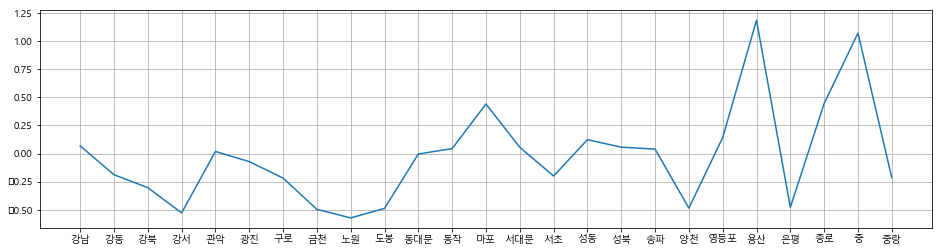

In [59]:
# 한글 폰트 깨지는 문제 #
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

# 시각화 그래프 # --> 구별 평균 추정값 (TEST)
price_pred = pd.DataFrame(mean['소득추정'])
price_pred.index = mean['location']
plt.figure()
plt.plot(price_pred, '-')
plt.rcParams['axes.grid'] = True
plt.rcParams["figure.figsize"] = (16,4)
plt.show()

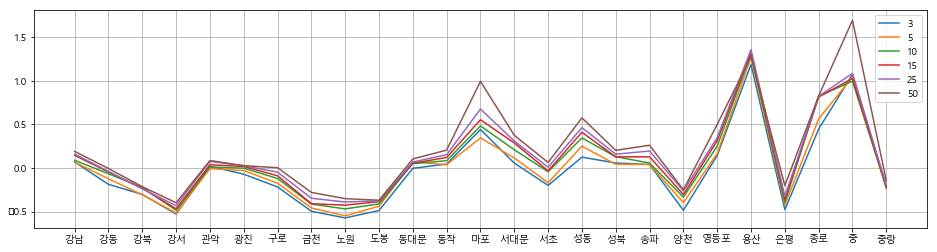

In [60]:
## k마다 평균추정치 비교 ##  main 코드 --> 구별 평균치 추정
plt.figure()
for i in range(len(k_list)):
    knn_fit = neg.KNeighborsRegressor(n_neighbors=k_list[i], p=2, metric='minkowski')
    knn_fit.fit(X, y_scale)
    x_test["predK%i" %k_list[i]] = knn_fit.predict(x_test.iloc[:, 1:3])
    mean = x_test.groupby(['location'], as_index=False).mean()
    price_pred = pd.DataFrame(mean.iloc[:, -1])
    price_pred.index = mean['location']
    plt.plot(price_pred)
plt.legend(k_list)
plt.rcParams['axes.grid'] = True
plt.rcParams["figure.figsize"] = (16,4)
plt.show()